In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.cluster import MiniBatchKMeans, KMeans
import pickle
import plotly.express as px
from sklearn import preprocessing
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception

from keras.models import Model
from keras import Sequential
from keras.layers import Flatten,Dense, Dropout
from keras.optimizers import SGD,Adam

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Load df

In [3]:
df=pd.read_pickle("dataframe.pkl")
df.image

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

In [4]:
df

,product_name,product_category_tree,image,description
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...
1,Sathiyas Cotton Bath Towel,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...
2,Eurospa Cotton Terry Face Towel Set,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Baby Care,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...
1046,Wallmantra Large Vinyl Sticker Sticker,Baby Care,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,Wallmantra Medium Vinyl Sticker Sticker,Baby Care,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...


#### Load image and resize
- get 128x128 size

In [5]:
from PIL import Image
list_img=[]
for i in range(0,df.shape[0]):
    #FILENAME='Images/'+df.image[i]
    #open Image + resize
    img = Image.open('Images/'+df.image[i]).resize((128, 128), Image.ANTIALIAS)
    #create img array matrix
    list_img.append(np.array(img))


C:\Users\Sirzesx\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


#### Encoder Label

In [6]:
le = preprocessing.LabelEncoder()

In [7]:
d = {'image': list_img, 'label': le.fit_transform(df.product_category_tree) }
df_img = pd.DataFrame(data=d)

In [8]:
cat_label=to_categorical(df_img.label, num_classes=7)
cat_label.shape

(1050, 7)

#### Create train, test, validation set

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_img.image,cat_label, test_size=0.2)

In [10]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train, test_size=0.1)

#### Define basic Resnet50 Model

In [11]:
#Defining the VGG Convolutional Neural Net
base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (128, 128,3), classes = y_train.shape[1])

#### Modify basic Resnet50 to adapt in our situation

In [12]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [13]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(512,activation=('relu'),input_dim=512))
#model.add(Dropout(.6))
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.6))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.5))
model.add(Dense(7,activation=('softmax')))

In [14]:
#model.summary()

#### Change shape format to adapt image processus for transfer learning

In [15]:
print((x_train.shape,y_train.shape))
print((x_validation.shape,y_validation.shape))
print((x_test.shape,y_test.shape))

((756,), (756, 7))
((84,), (84, 7))
((210,), (210, 7))


In [16]:
x_train=np.stack([x_train[x_train.index[i]] for i in range(x_train.shape[0])], axis=0)
x_validation=np.stack([x_validation[x_validation.index[i]] for i in range(x_validation.shape[0])], axis=0)
x_test=np.stack([x_test[x_test.index[i]] for i in range(x_test.shape[0])], axis=0)

In [17]:
print((x_train.shape,y_train.shape))
print((x_validation.shape,y_validation.shape))
print((x_test.shape,y_test.shape))

((756, 128, 128, 3), (756, 7))
((84, 128, 128, 3), (84, 7))
((210, 128, 128, 3), (210, 7))


#### Augmentation Image

In [18]:
#Image Data Augmentation
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_validation)
test_generator.fit(x_test)

#### Initializing the hyperparameters

In [19]:
#Initializing the hyperparameters
batch_size= 32
epochs=50
learn_rate=.0005
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])
##"rmsprop"

#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)

#Stop training when a monitored metric has stopped improving
EStop=EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

#ModelCheckP=ModelCheckpoint(filepath,monitor="val_accuracy",verbose=0,save_best_only=False,save_weights_only=False,
#    mode="auto",save_freq="epoch",options=None,**kwargs)

C:\Users\Sirzesx\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


#### Generator image

In [20]:
train_data=train_generator.flow(x_train, y_train, batch_size = batch_size)
valid_data=val_generator.flow(x_validation, y_validation, batch_size = batch_size)

#### Train/val

In [21]:
history=model.fit(train_data, epochs=epochs, steps_per_epoch = len(x_train)//batch_size, validation_data=valid_data, validation_steps=len(x_validation)//batch_size, verbose=1, callbacks = [lrr])

#history = model.fit(x=x_train, y=y_train, epochs=epochs, steps_per_epoch=len(x_train)//batch_size, validation_data = (x_validation, y_validation), validation_steps = 250, callbacks=[lrr], verbose = 1)

Epoch 1/50
23/23 [==============================] - 32s 253ms/step - loss: 3.5347 - accuracy: 0.1756 - val_loss: 1.6564 - val_accuracy: 0.4062
Epoch 2/50
23/23 [==============================] - 3s 127ms/step - loss: 1.9084 - accuracy: 0.3220 - val_loss: 1.7170 - val_accuracy: 0.2656
Epoch 3/50
23/23 [==============================] - 3s 126ms/step - loss: 1.6503 - accuracy: 0.3826 - val_loss: 1.3658 - val_accuracy: 0.5312
Epoch 4/50
23/23 [==============================] - 3s 132ms/step - loss: 1.2020 - accuracy: 0.5720 - val_loss: 1.1204 - val_accuracy: 0.5781
Epoch 5/50
23/23 [==============================] - 3s 130ms/step - loss: 1.1184 - accuracy: 0.5752 - val_loss: 0.9056 - val_accuracy: 0.6094
Epoch 6/50
23/23 [==============================] - 3s 132ms/step - loss: 0.9097 - accuracy: 0.6766 - val_loss: 0.8391 - val_accuracy: 0.7031
Epoch 7/50
23/23 [==============================] - 6s 263ms/step - loss: 0.8124 - accuracy: 0.6981 - val_loss: 0.9539 - val_accuracy: 0.6406
Epoch

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

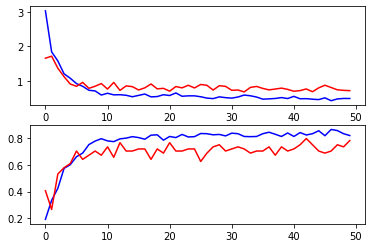

In [23]:
#Plotting the training and validation loss
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column
#Training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')
#Training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')


In [24]:
class_list=[thing for thing in range(7)]
class_list=le.inverse_transform(class_list)
class_list

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [25]:
x = x_test[50]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', preds.argmax()+1, ": ", preds.max())
print('Reel:',y_test[50].argmax()+1)

Predicted: 6 :  0.31519943
Reel: 7


#### Test data 

In [26]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 3s 621ms/step - loss: 0.6044 - accuracy: 0.8238
test loss, test acc: [0.6043522953987122, 0.8238095045089722]


In [27]:
labels=[]
for i in range(7):
    labels.append(i)

In [28]:
def predict_image_class(image):
    #img = Image.open('Images/'+df.image[i]).resize((128, 128), Image.ANTIALIAS)
    #create img array matrix
    x= np.array(image)
    #expand the dims of the shape (1,2)=> (1,1,2)
    x = np.expand_dims(x, axis=0)
    #preprocess Transfert Learning by ResNet
    x = preprocess_input(x)
    preds = model.predict(x)
    return {class_list[i]: float(preds[0][i]) for i in range(7)}

In [29]:
import gradio as gr
import numpy as np

image = gr.inputs.Image(shape=(128, 128))
label = gr.outputs.Label(num_top_classes=7)

gr.Interface(fn=predict_image_class, inputs=image, outputs=label, capture_session=True).launch(share=True)

Running locally at: http://127.0.0.1:7860/
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://39241.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://39241.gradio.app')